In [1]:
from scripts.estimate_roa import load_ground_truth
import os
from os import path
import genMoPlan
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

os.chdir("/common/home/st1122/Projects/genMoPlan/")

In [2]:
dataset = "pendulum_lqr_50k"
path_prefix = "diffusion"

In [3]:
gt_data = load_ground_truth(dataset)
start_points = gt_data[:, :2]
expected_labels = gt_data[:, 2]

[ scripts/estimate_roa ] Loading ground truth


In [4]:
from scripts.estimate_roa import load_dataset_params

params = load_dataset_params(dataset)
attractors = params["attractors"]
attractor_threshold = params["attractor_threshold"]
invalid_label = params["invalid_label"]
attractor_probability_upper_threshold = params["attractor_probability_upper_threshold"]

ImportError: cannot import name 'load_dataset_params' from 'scripts.estimate_roa' (/common/home/st1122/Projects/mg_diffuse/scripts/estimate_roa.py)

In [5]:
from scripts.estimate_roa import get_labels_array


start_points = gt_data[:, :2]
expected_labels = gt_data[:, 2]

labels_set, labels_array = get_labels_array(expected_labels, invalid_label)

In [6]:
exp_name = "25_02_16-18_04_46_H32_T20_PADT_EPSF_ATNF_LD1_data_lim_1000"
timestamp = '2025-02-20_18-37-43'

n_runs = 100
model_state_name = "best.pt"

exp_path = path.join("experiments", dataset, path_prefix, exp_name)
gen_traj_path = path.join(exp_path, "generated_trajectories", timestamp)

In [7]:
from scripts.estimate_roa import load_final_states_data

final_states_path = path.join("experiments", dataset, path_prefix, exp_name, "generated_trajectories", timestamp)

all_predicted_labels, all_final_states = load_final_states_data(final_states_path, n_runs, invalid_label)
all_final_states = all_final_states.transpose(1, 0, 2)
all_predicted_labels = all_predicted_labels.transpose(1, 0)

[ scripts/estimate_roa ] Loading attractor labels


 20%|██        | 20/100 [00:39<02:38,  1.98s/it]

[ scripts/estimate_roa ] File experiments/pendulum_lqr_50k/diffusion/25_02_16-18_04_46_H32_T20_PADT_EPSF_ATNF_LD1_data_lim_1000/generated_trajectories/2025-02-20_18-37-43/attractor_labels_20.txt not found
Invalid labels count: 5029338


In [8]:
attractor_labels = [
    "Fail - Left",
    "Fail - Right",
    "Success",
]

attractor_coordinates = [
    np.array([-2.1, 0]),
    np.array([2.1, 0]),
    np.array([0, 0]),
]

In [9]:
attractor_threshold = 0.05

In [10]:
closest_attractor_indices = []
closest_attractor_distances = []

for i, start_point in tqdm(enumerate(start_points)):
    final_states_across_runs = all_final_states[i]

    # Calculate distances to all attractors for each final state
    attractor_distances = np.array([
        np.linalg.norm(final_states_across_runs - attractor_coord, axis=1) 
        for attractor_coord in attractor_coordinates
    ])
    
    # Get index of closest attractor and corresponding distance for each final state
    closest_attractor_idx = np.argmin(attractor_distances, axis=0)
    min_distances = np.min(attractor_distances, axis=0)

    # If the minimum distance is greater than the attractor threshold, set the label to invalid
    closest_attractor_idx[min_distances > attractor_threshold] = invalid_label

    closest_attractor_indices.append(closest_attractor_idx)
    closest_attractor_distances.append(min_distances)
    
closest_attractor_distances = np.array(closest_attractor_distances, dtype=np.float32)
closest_attractor_indices = np.array(closest_attractor_indices, dtype=np.int32)

790653it [00:19, 40494.67it/s]


In [11]:
# Calculate probabilities for each attractor efficiently using numpy operations
n_points = len(start_points)
n_attractors = len(attractor_labels) + 1  # Add 1 for invalid label

# Use numpy's bincount to count occurrences for each point and attractor
# Reshape to handle all points at once
flattened_indices = closest_attractor_indices.reshape(-1)
point_indices = np.repeat(np.arange(n_points), closest_attractor_indices.shape[1])

# Create a 2D array of counts using advanced indexing
counts = np.zeros((n_points, n_attractors))
np.add.at(counts, (point_indices, flattened_indices), 1)

# Convert counts to probabilities by dividing by number of runs
probabilities = counts / closest_attractor_indices.shape[1]

print("Probabilities shape:", probabilities.shape)
print("\nSample probabilities for first 5 points:")
for i in range(min(5, n_points)):
    probs_dict = {label: f"{prob:.3f}" for label, prob in zip(attractor_labels, probabilities[i, :-1])}
    print(f"Point {i}:", f"Start point: {start_points[i]}", 
          probs_dict,
          f"Invalid: {probabilities[i, -1]:.3f}")


Probabilities shape: (790653, 4)

Sample probabilities for first 5 points:
Point 0: Start point: [-3.14 -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000
Point 1: Start point: [-3.13 -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000
Point 2: Start point: [-3.12 -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000
Point 3: Start point: [-3.11 -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000
Point 4: Start point: [-3.1  -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000


In [5]:
# Plot probability of attractor label 1
plt.figure(figsize=(8, 8))
plt.scatter(start_points[:, 0], start_points[:, 1], 
           c=probabilities[:, 0], s=1, cmap='viridis')
plt.colorbar(label='Probability')
plt.title(f'Probability of label {attractor_labels[0]}')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


NameError: name 'probabilities' is not defined

<Figure size 800x800 with 0 Axes>

In [12]:
# Get the attractor probability upper threshold from config
attractor_probability_upper_threshold = params["attractor_probability_upper_threshold"]

# Find points where any attractor (including invalid) has probability above threshold
certain_mask = np.any(probabilities >= attractor_probability_upper_threshold, axis=1)

# Get indices of certain and uncertain points
certain_indices = np.where(certain_mask)[0]
uncertain_indices = np.where(~certain_mask)[0]

# For certain points, get the label with highest probability (including invalid label)
all_probs = np.column_stack([probabilities, 
                            counts[:,-1]/closest_attractor_indices.shape[1]])
certain_labels = np.argmax(all_probs[certain_mask], axis=1)

# Store the results
certain_points = start_points[certain_indices]
certain_point_labels = certain_labels
uncertain_points = start_points[uncertain_indices]
invalid_mask = certain_point_labels == len(attractor_labels)
invalid_points = certain_points[invalid_mask]

print(f"\nNumber of certain points: {len(certain_points)}")
print(f"Number of uncertain points: {len(uncertain_points)}")
print("\nLabel distribution for certain points:")
unique_labels, label_counts = np.unique(certain_point_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    if label < len(attractor_labels):
        print(f"Attractor {attractor_labels[label]}: {count}")
    else:
        print(f"Invalid: {count}")



Number of certain points: 781359
Number of uncertain points: 9294

Label distribution for certain points:
Attractor Fail - Left: 223278
Attractor Fail - Right: 13205
Attractor Success: 294830
Invalid: 250046


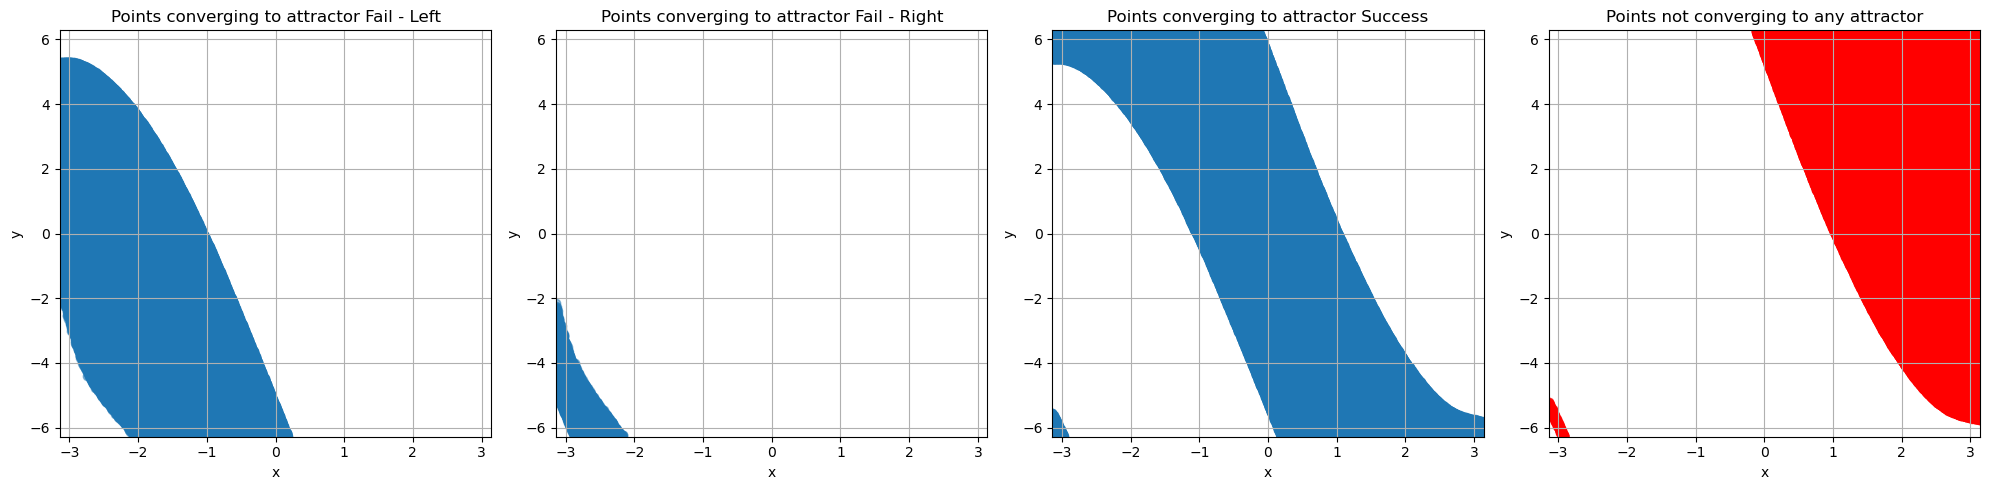

In [13]:
import matplotlib.pyplot as plt

# Create a figure with subplots for each attractor and invalid points
n_plots = len(attractor_labels) + 1  # +1 for invalid points
fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))

# Get overall min and max for x and y coordinates
x_min = certain_points[:, 0].min()
x_max = certain_points[:, 0].max()
y_min = certain_points[:, 1].min()
y_max = certain_points[:, 1].max()

# Plot points for each attractor
for i, label in enumerate(attractor_labels):
    mask = certain_point_labels == i
    axes[i].scatter(certain_points[mask, 0], certain_points[mask, 1], alpha=0.5)
    axes[i].set_title(f'Points converging to attractor {label}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)

# Plot invalid points

axes[-1].scatter(certain_points[invalid_mask, 0], certain_points[invalid_mask, 1], alpha=0.5, color='red')
axes[-1].set_title('Points not converging to any attractor')
axes[-1].set_xlabel('x')
axes[-1].set_ylabel('y')
axes[-1].grid(True)
axes[-1].set_xlim(x_min, x_max)
axes[-1].set_ylim(y_min, y_max)

plt.tight_layout()

In [14]:
# Get final states for points labeled as invalid
invalid_mask = certain_point_labels == len(attractor_labels)
invalid_final_states = all_final_states[certain_indices[invalid_mask]]
print("Final states shape for invalid points:", invalid_final_states.shape)
print("\nSample of final states for invalid points:")
print(invalid_final_states[:])

Final states shape for invalid points: (250046, 20, 2)

Sample of final states for invalid points:
[[[ 2.057801    0.03807809]
  [ 2.0634155   0.04690753]
  [ 2.0634096   0.04639661]
  ...
  [ 2.0581706   0.03407512]
  [ 2.0673895   0.04475273]
  [ 2.0570374   0.04660254]]

 [[ 2.0627367   0.04604268]
  [ 2.0656154   0.047265  ]
  [ 2.0651212   0.04938526]
  ...
  [ 2.0679529   0.04593823]
  [ 2.066087    0.0490576 ]
  [ 2.0600967   0.04313884]]

 [[ 2.067869    0.04224817]
  [ 2.0652733   0.04957103]
  [ 2.0661817   0.04910039]
  ...
  [ 2.066438    0.04854749]
  [ 2.0664914   0.04430921]
  [ 2.06818     0.04707247]]

 ...

 [[-2.0403895  -0.05738747]
  [-2.0419433  -0.06021632]
  [-2.038191   -0.05779418]
  ...
  [-2.0436597  -0.05308849]
  [-2.041756   -0.0563575 ]
  [-2.0383801  -0.06107135]]

 [[-2.038317   -0.05567997]
  [-2.0409486  -0.05792587]
  [-2.0392952  -0.06126311]
  ...
  [-2.0416396  -0.06111203]
  [-2.0384915  -0.05947583]
  [-2.041817   -0.05704102]]

 [[-2.0414882  

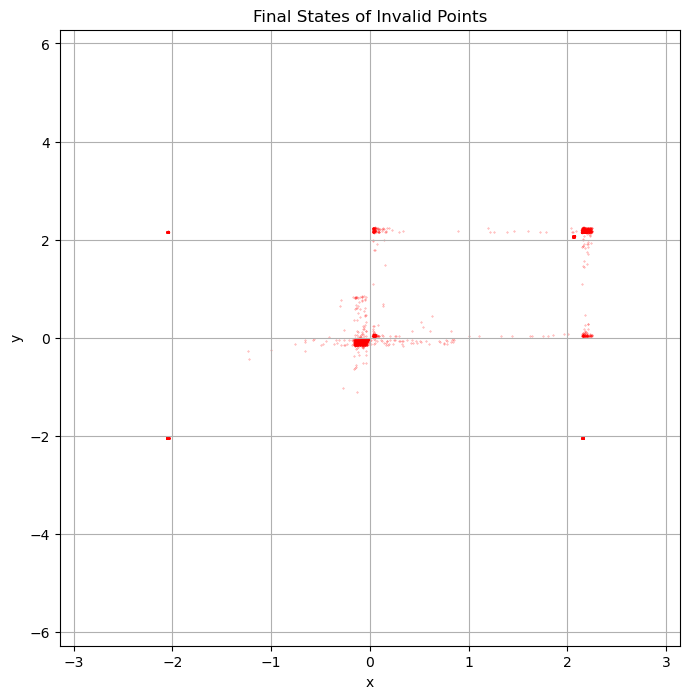

In [15]:
# Create a scatter plot of invalid final states
plt.figure(figsize=(8, 8))
plt.scatter(invalid_final_states[:, 0], invalid_final_states[:, 1], alpha=0.5, color='red', s=0.1)
plt.title('Final States of Invalid Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.xlim(axes[0].get_xlim())  # Use same x limits as first attractor plot
plt.ylim(axes[0].get_ylim())  # Use same y limits as first attractor plot


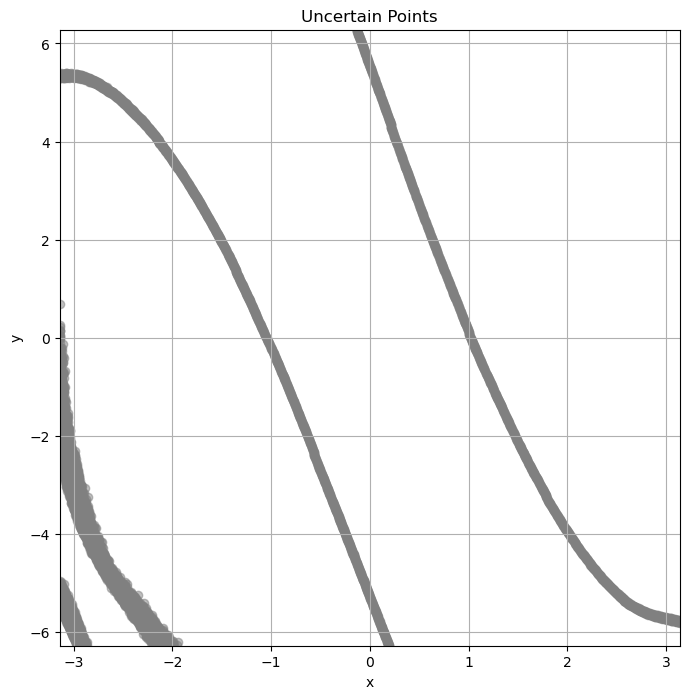

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(uncertain_points[:, 0], uncertain_points[:, 1], alpha=0.5, color='gray')
plt.title('Uncertain Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.xlim(x_min, x_max)  # Use same limits as previous plots
plt.ylim(y_min, y_max)



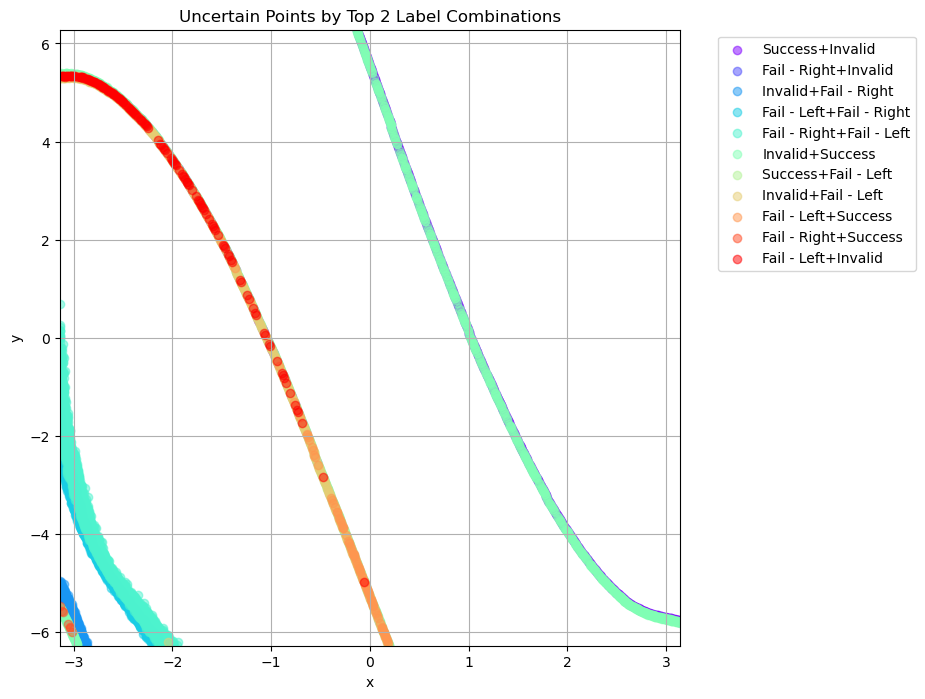

In [17]:
# Get top 2 dominant labels for uncertain points
uncertain_probabilities = probabilities[uncertain_indices]
label_combinations = []
points_by_combination = []

for point_idx, point_probs in enumerate(uncertain_probabilities):
    # Get indices of top 2 highest probabilities
    top_2_indices = np.argsort(point_probs)[-2:]
    # Convert to tuple for hashing
    label_combo = tuple([attractor_labels[label_idx] if label_idx < len(attractor_labels) else "Invalid" for label_idx in top_2_indices])
    
    if label_combo not in label_combinations:
        label_combinations.append(label_combo)
        points_by_combination.append([uncertain_points[point_idx]])
    else:
        combo_idx = label_combinations.index(label_combo)
        points_by_combination[combo_idx].append(uncertain_points[point_idx])

# Convert lists of points to numpy arrays
points_by_combination = [np.array(points) for points in points_by_combination]

# Create plot
plt.figure(figsize=(8, 8))

# Use a different color for each combination
colors = plt.cm.rainbow(np.linspace(0, 1, len(label_combinations)))

for i, (combo, points) in enumerate(zip(label_combinations, points_by_combination)):
    label_str = f"{'+'.join(str(l) for l in combo)}"
    plt.scatter(points[:, 0], points[:, 1], alpha=0.5, color=colors[i], label=label_str)

plt.title('Uncertain Points by Top 2 Label Combinations')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [18]:
separatrix_points = np.concatenate([uncertain_points, invalid_points])

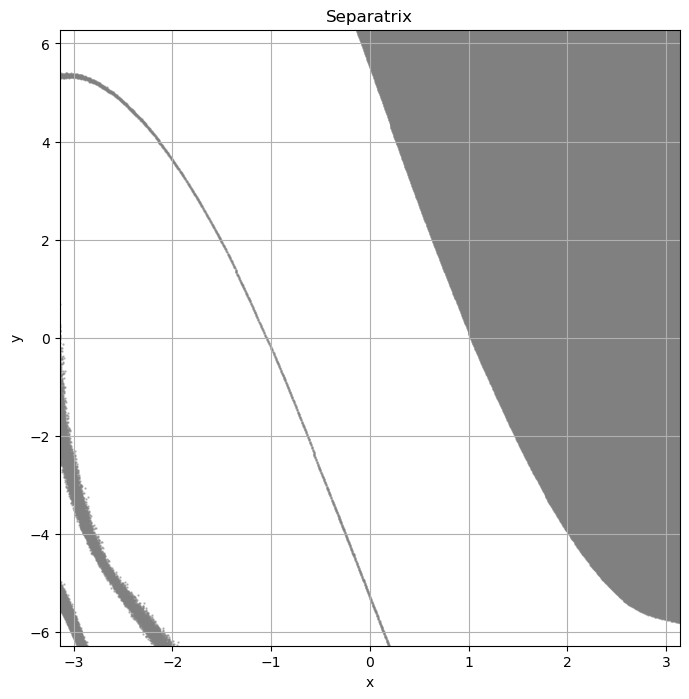

In [19]:
plt.figure(figsize=(8, 8))
plt.title('Separatrix')
plt.scatter(separatrix_points[:, 0], separatrix_points[:, 1], alpha=0.5, color='gray', s=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.xlim(x_min, x_max)  # Use same limits as previous plots
plt.ylim(y_min, y_max)

In [2]:
import genMoPlan.utils as utils
import numpy as np

In [3]:
trajectories = utils.load_trajectories('pendulum_lqr_5k', 100)

[ datasets/sequence ] Loading trajectories from data_trajectories/pendulum_lqr_5k/trajectories


100%|██████████| 100/100 [00:00<00:00, 784.81it/s]


[[-0.74954775 -3.20357003]
 [ 1.7340782  -0.85980186]
 [-3.80979807  4.19844334]
 [ 4.84745922 -2.90209885]
 [-0.52842184 -2.10937033]]


([], [])

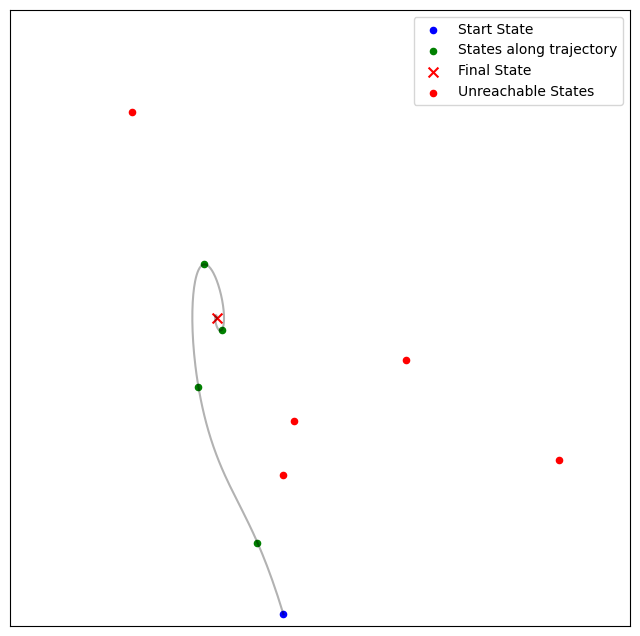

In [30]:
trajectory = trajectories[23]

plt.figure(figsize=(8, 8))

# Plot full trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], color='black', alpha=0.3)

# Plot start point
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='blue', s=20, label='Start State')

# Plot 5 random points
random_indices = [10, 50, 100, 200]
plt.scatter(trajectory[random_indices, 0], trajectory[random_indices, 1], color='green', s=20, label='States along trajectory')

# Plot end point as red cross
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', marker='x', s=50, label='Final State')

# Generate random points in state space
num_points = 5
random_points = np.random.uniform(low=-2*np.pi, high=2*np.pi, size=(num_points, 2))
print(random_points)
plt.scatter(random_points[:, 0], random_points[:, 1], color='red', alpha=1, s=20, label='Unreachable States')


plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(-2*np.pi, 2*np.pi)
plt.legend()
plt.xticks([])
plt.yticks([])


